## CAPSTONE PROJECT #1: Deep Demographic Insights from Amazon Customer Data

Summary: With this project, I plan to explore the demographics of our current customer base in order to determine better who to target with our marketing and which messages may resonate more soundly with them. To this end, I will use the customizable order reports that Amazon provides to its sellers through its Seller Central portal as a dataset. These reports include data such as purchase items & quantity, name, address, city, state, and zip code. I will also use datasets from data.gov for the demographic data with which I will perform my analyses. Data will be visualized here in ways that make the insights most clear.

In [88]:
#Imports
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import calendar

In [89]:
#Read in data.gov dataset (only selecting columns of interest)
demo_data_RAW = pd.read_csv('16zpallagi.csv', usecols=['zipcode', 'agi_stub', 'N1', 'NUMDEP', 'ELDERLY', 'A00100',
                                                      'mars1', 'MARS2', 'MARS4'])
#  ZIPCODE	5-digit Zip code
#  AGI_STUB	Size of adjusted gross income
    #1 = $1 under $25,000
    #2 = $25,000 under $50,000
    #3 = $50,000 under $75,000
    #4 = $75,000 under $100,000
    #5 = $100,000 under $200,000
    #6 = $200,000 or more
#  N1	Number of returns
#  NUMDEP	Number of dependents
#  ELDERLY	Number of elderly returns [4]
#  A00100	Adjust gross income (AGI) [2] (in Thousands)
#  MARS1	Number of single returns	  Filing status is single
#  MARS2	Number of joint returns	  Filing status is married filing jointly
#  MARS4	Number of head of household returns	  Filing status is head of household


In [90]:
#Create new copy for cleaning/modification
demo_data = demo_data_RAW.copy()

In [91]:
print(demo_data_RAW.head(15))
print(demo_data_RAW.tail(15))

    zipcode  agi_stub      N1   mars1   MARS2   MARS4  NUMDEP  ELDERLY  \
0         0         1  815440  477700  105350  221200  491310   150920   
1         0         2  495830  211930  142340  128890  360480   109680   
2         0         3  263390   83420  137870   36340  182880    75570   
3         0         4  167190   29420  124060   10610  130160    51540   
4         0         5  217440   20240  188080    4880  195990    68080   
5         0         6   57240    2970   51130     400   56220    19330   
6     35004         1    1510     990     220     280     660      340   
7     35004         2    1410     660     360     340     900      270   
8     35004         3     950     330     470     140     660      200   
9     35004         4     650     120     470      50     560      130   
10    35004         5     630      50     560      20     610      130   
11    35004         6      60       0      60       0      40       20   
12    35005         1    1310     760 

In [92]:
#(SEE BELOW)
def format_postal_codes(row):
    zipcode = row['zipcode']
    return zipcode[:5].zfill(5) #Only keep 1st 5 digits and add leading zeroes to 4-digit codes

In [93]:
#Clean demo data (use copy of dataframe, demo_data)
#1. Remove summary rows (zipcode = 0, totaled AGI for brackets 1-6)
#2. "ZIP codes with less than 100 returns and those identified as a single building or 
    #nonresidential ZIP code were categorized as “other” (99999)." -> Remove zipcode = 99999
    
demo_data = demo_data[(demo_data['zipcode'] != 0) & (demo_data['zipcode'] != 99999)]

#Ensure no NULL or NaN values
assert demo_data.notna().any().any()
assert demo_data.notnull().any().any()

#Fix zip code formatting (SEE BELOW)
demo_data['zipcode'] = demo_data['zipcode'].astype(str)
demo_data_badzip = demo_data[demo_data['zipcode'].str.len() < 5]
print(demo_data_badzip.head())
print(demo_data_badzip.shape)

demo_data['zipcode'] = demo_data.apply(format_postal_codes, axis=1)

demo_data_badzip = demo_data[demo_data['zipcode'].str.len() < 5]
print(demo_data_badzip.shape)

print(demo_data.head(15))
print(demo_data.tail(15))

      zipcode  agi_stub    N1  mars1  MARS2  MARS4  NUMDEP  ELDERLY  A00100
22290    6001         1  2170   1930    150     70     160      490   20138
22291    6001         2   980    660    190    100     280      340   36335
22292    6001         3   990    570    310     80     360      380   61690
22293    6001         4   840    350    400     70     460      360   73155
22294    6001         5  2170    380   1640    110    1920      820  311741
(13942, 9)
(0, 9)
   zipcode  agi_stub    N1  mars1  MARS2  MARS4  NUMDEP  ELDERLY  A00100
6    35004         1  1510    990    220    280     660      340   19351
7    35004         2  1410    660    360    340     900      270   51976
8    35004         3   950    330    470    140     660      200   58988
9    35004         4   650    120    470     50     560      130   56302
10   35004         5   630     50    560     20     610      130   81057
11   35004         6    60      0     60      0      40       20   19929
12   35005     

In [94]:
#Read in Amazon order data files (only selecting columns of interest)

amzn_files = glob.glob('amzn_*.csv')
frames = []

for amzn_file in amzn_files:
    df = pd.read_csv(amzn_file, 
                     usecols=['amazon-order-id', 'ship-city', 'ship-state', 'ship-postal-code', 
                                         'purchase-date', 'order-status', 'item-price'], 
                     parse_dates=['purchase-date'])
    frames.append(df)
    
amzn_data_RAW = pd.concat(frames)

print(amzn_data_RAW)

        amazon-order-id       purchase-date order-status  item-price  \
0   113-9235397-9394658 2017-04-27 16:14:10      Shipped       74.99   
1   112-1718234-0365053 2017-04-25 18:03:59      Shipped       74.99   
2   111-1795457-0212247 2017-04-24 17:07:36      Shipped       74.99   
3   114-9388024-7222668 2017-04-24 03:07:35      Shipped       59.99   
4   112-7199274-2267420 2017-04-24 00:19:53      Shipped       59.99   
5   114-1820375-9374655 2017-04-23 21:35:19      Shipped       74.99   
6   114-5537230-7035440 2017-04-23 15:38:21      Shipped       59.99   
7   111-3030846-5669813 2017-04-23 13:20:40      Shipped       24.99   
8   114-9465164-0336206 2017-04-17 03:19:20      Shipped       59.99   
0   S01-7392974-6758607 2018-04-20 14:49:17      Shipped         NaN   
1   S01-0687176-5762612 2018-04-20 14:43:09      Shipped         NaN   
2   S01-7409097-5605043 2018-04-13 20:44:31      Shipped         NaN   
3   S01-1331848-4965831 2018-04-04 19:59:27      Shipped        

In [95]:
#Create new copy for cleaning/modification
amzn_data = amzn_data_RAW.copy()

In [96]:
def format_postal_codes(row):
    zipcode = row['ship-postal-code']
    return zipcode[:5] #Only keep 1st 5 digits

In [97]:
#Clean amzn data (use copy of dataframe, amzn_data)
#1. Remove order status = cancelled (Cancelled purchases)
#2. Remove item-price == NaN (Internal orders)
#3. Re-format postal codes to 5-digit

amzn_data = amzn_data[(amzn_data['order-status'] != 'Cancelled') & (amzn_data['item-price'].isna() == False)]

amzn_data['ship-postal-code'] = amzn_data.apply(format_postal_codes, axis=1)

print(amzn_data)

        amazon-order-id       purchase-date order-status  item-price  \
0   113-9235397-9394658 2017-04-27 16:14:10      Shipped       74.99   
1   112-1718234-0365053 2017-04-25 18:03:59      Shipped       74.99   
2   111-1795457-0212247 2017-04-24 17:07:36      Shipped       74.99   
3   114-9388024-7222668 2017-04-24 03:07:35      Shipped       59.99   
4   112-7199274-2267420 2017-04-24 00:19:53      Shipped       59.99   
5   114-1820375-9374655 2017-04-23 21:35:19      Shipped       74.99   
6   114-5537230-7035440 2017-04-23 15:38:21      Shipped       59.99   
7   111-3030846-5669813 2017-04-23 13:20:40      Shipped       24.99   
8   114-9465164-0336206 2017-04-17 03:19:20      Shipped       59.99   
4   111-3229512-8978653 2018-04-27 03:15:37      Shipped       54.74   
5   114-4995916-0673839 2018-04-26 15:23:28      Shipped       24.99   
6   114-9754322-0085045 2018-04-26 02:59:24      Shipped      138.48   
7   111-9127896-9380206 2018-04-23 22:53:19      Shipped       2

In [98]:
#Inspection reveals that some postal codes only contain 4 digits... Investigate extent of missing data

amzn_data_badzip = amzn_data[amzn_data['ship-postal-code'].str.len() < 5]
print(amzn_data_badzip)
print(amzn_data_badzip.shape) #17 entries with malformed zip codes

         amazon-order-id       purchase-date order-status  item-price  \
23   111-9609861-8962606 2017-08-03 00:37:46      Shipped       54.74   
25   112-7960702-7423409 2017-12-15 16:03:46      Shipped       69.24   
60   113-2505608-4685062 2017-12-03 15:57:46      Shipped       54.74   
27   114-6338329-2369861 2018-12-01 23:47:19      Shipped       49.95   
33   113-7187912-3566607 2018-01-07 17:52:45      Shipped       47.96   
7    112-3353580-9406617 2018-07-29 20:21:57      Shipped       54.74   
32   113-5301065-5353862 2017-06-16 11:24:38      Shipped       54.74   
3    113-7643260-4752269 2018-06-17 00:35:30      Shipped       54.74   
4    113-7308728-5227457 2018-06-15 09:06:10      Shipped       24.99   
21   113-5998718-4616234 2017-11-26 23:50:19      Shipped       69.24   
25   113-8802782-0385053 2017-11-25 23:05:36      Shipped       69.24   
63   112-8664992-4798652 2017-11-15 00:38:29      Shipped       54.74   
106  114-9456570-9773828 2017-11-01 12:35:57      S

In [99]:
#Research confirms that for the cities and states with malformed zip codes, the zip codes begin with 0.
#Excel truncates the leading zero. 

def format_postal_codes_2(row):
    zipcode = row['ship-postal-code']
    return zipcode[:5].zfill(5) #Only keep 1st 5 digits and add leading zeroes to 4-digit codes

In [100]:
amzn_data['ship-postal-code'] = amzn_data.apply(format_postal_codes_2, axis=1)

print(amzn_data.tail())

amzn_data_badzip = amzn_data[amzn_data['ship-postal-code'].str.len() < 5]
#print(amzn_data_badzip)
print(amzn_data_badzip.shape) #0 entries with malformed zip codes

        amazon-order-id       purchase-date order-status  item-price  \
40  113-4612537-0217801 2018-09-04 04:34:59      Shipped       54.74   
41  111-5578098-9537809 2018-09-04 01:32:04      Shipped       54.74   
42  113-0993551-9994608 2018-09-02 15:49:07      Shipped       54.74   
43  112-7773237-9239423 2018-09-01 22:41:55      Shipped       69.24   
44  112-9473577-0963450 2018-09-01 20:54:35      Shipped       54.74   

       ship-city ship-state ship-postal-code  
40     SAN DIEGO         CA            92116  
41       LA MESA         CA            91941  
42        DELAND         FL            32720  
43      Sun City         AZ            85351  
44  North Bergen         NJ            07047  
(0, 7)


In [101]:
#Cleaning complete - strip unnecessary columns

amzn_data = amzn_data[['amazon-order-id', 'purchase-date', 'ship-postal-code']]
print(amzn_data.head())

       amazon-order-id       purchase-date ship-postal-code
0  113-9235397-9394658 2017-04-27 16:14:10            02118
1  112-1718234-0365053 2017-04-25 18:03:59            98802
2  111-1795457-0212247 2017-04-24 17:07:36            64506
3  114-9388024-7222668 2017-04-24 03:07:35            94022
4  112-7199274-2267420 2017-04-24 00:19:53            80231


In [102]:
#Reshape demo_data
#demo_data = demo_data.set_index(['zipcode', 'agi_stub'])

In [103]:
demo_data.head(10)

,zipcode,agi_stub,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100
6,35004,1,1510,990,220,280,660,340,19351
7,35004,2,1410,660,360,340,900,270,51976
8,35004,3,950,330,470,140,660,200,58988
9,35004,4,650,120,470,50,560,130,56302
10,35004,5,630,50,560,20,610,130,81057
11,35004,6,60,0,60,0,40,20,19929
12,35005,1,1310,760,160,380,830,280,17792
13,35005,2,960,410,230,300,720,210,34741
14,35005,3,450,130,190,120,340,120,27410
15,35005,4,200,40,150,30,140,50,17202


In [104]:
amzn_zip_count = amzn_data[['ship-postal-code', 'amazon-order-id']].groupby('ship-postal-code').count().rename(columns={'amazon-order-id':'count'})
amzn_zip_count = amzn_zip_count.sort_values('count', ascending=False)
amzn_zip_count.head(10)

,count
ship-postal-code,
92110,14
07020,4
22902,3
22207,3
97230,3
76248,3
33613,3
54843,3
33183,3


In [105]:
#Multi-index demo_data
demo_data = demo_data.set_index(['zipcode', 'agi_stub'])
demo_data.head()

N1  mars1  MARS2  MARS4  NUMDEP  ELDERLY  A00100
zipcode agi_stub                                                    
35004   1         1510    990    220    280     660      340   19351
        2         1410    660    360    340     900      270   51976
        3          950    330    470    140     660      200   58988
        4          650    120    470     50     560      130   56302
        5          630     50    560     20     610      130   81057

In [106]:
#demo_data.index = demo_data.index.astype('object')
#demo_data.index.levels[0] = demo_data.index.levels[0].astype('object')
a = demo_data.index.levels[0].astype(str)
b = demo_data.index.levels[1].astype('int64')
demo_data.index = demo_data.index.set_levels([a,b])
demo_data.index.levels[0]

Index([u'01001', u'01002', u'01003', u'01005', u'01007', u'01008', u'01009',
       u'01010', u'01011', u'01012',
       ...
       u'99833', u'99835', u'99840', u'99901', u'99919', u'99921', u'99922',
       u'99925', u'99926', u'99929'],
      dtype='object', name=u'zipcode', length=29872)

In [107]:
amzn_zip_count.index = amzn_zip_count.index.rename('zipcode')
amzn_zip_count.index = amzn_zip_count.index.astype('str')
amzn_zip_count.index

Index([u'92110', u'07020', u'22902', u'22207', u'97230', u'76248', u'33613',
       u'54843', u'33183', u'27519',
       ...
       u'33129', u'32953', u'32839', u'32835', u'32803', u'32766', u'32720',
       u'32714', u'32708', u'99824'],
      dtype='object', name=u'zipcode', length=571)

In [108]:
joint_data = amzn_zip_count.join(demo_data)
print(joint_data.head(10))
print(joint_data.shape)

                  count   N1  mars1  MARS2  MARS4  NUMDEP  ELDERLY  A00100
zipcode agi_stub                                                          
35175   1             2  730    450    170    100     320      170    9283
        2             2  510    210    240     70     300      150   18853
        3             2  300     70    200     50     220       90   18803
        4             2  210     30    180      0     160       70   18216
        5             2  270     20    240      0     220       90   35919
        6             2   40      0     40      0      30       20   20384
99824   1             1  270    220      0     30      70       30    3009
        2             1  260    180     30     40      80       40    9660
        3             1  210    130     50     40      80       50   13128
        4             1  150     70     70      0      50       50   12806
(3396, 8)


In [109]:
#Discard AGI Bins & Sum

joint_grouped = joint_data.reset_index()
joint_grouped = joint_grouped.groupby('zipcode').sum()
joint_grouped['count'] = joint_grouped['count'] / 6
joint_grouped['count'] = joint_grouped['count'].astype(int)
joint_grouped = joint_grouped.drop('agi_stub', axis=1)
joint_grouped = joint_grouped.sort_values('count', ascending=False)
joint_grouped

,count,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100
zipcode,,,,,,,,
92110,14,13130,8030,3730,1100,5000,3010,983303
07020,4,6130,2940,2380,610,2880,1240,850117
54843,3,5840,2750,2400,640,2900,2030,306851
22207,3,15000,6650,7270,770,10280,4190,3501311
94708,3,5950,2900,2730,230,2360,2550,1136310
27519,3,24290,8150,14140,1550,22650,4060,2984147
94117,3,23140,17440,4600,710,4310,2850,3644629
33183,3,18650,9250,5030,3980,10620,3400,820700
22902,3,11150,6310,3340,1240,5540,2350,988292


In [110]:
#Perform arithmetic operations
joint_grouped['avg_AGI'] = joint_grouped['A00100'] / joint_grouped['N1']
joint_grouped['%_single'] = joint_grouped['mars1'] / joint_grouped['N1'] * 100
joint_grouped['%_married'] = joint_grouped['MARS2'] / joint_grouped['N1'] * 100
joint_grouped['%_HOH'] = joint_grouped['MARS4'] / joint_grouped['N1'] * 100
joint_grouped['%_elderly'] = joint_grouped['ELDERLY'] / joint_grouped['N1'] * 100
joint_grouped['avg_DEP'] = joint_grouped['NUMDEP'] / (joint_grouped['MARS2'] + joint_grouped['MARS4'])

joint_grouped

,count,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100,avg_AGI,%_single,%_married,%_HOH,%_elderly,avg_DEP
zipcode,,,,,,,,,,,,,,
92110,14,13130,8030,3730,1100,5000,3010,983303,74.889794,61.157654,28.408225,8.377761,22.924600,1.035197
07020,4,6130,2940,2380,610,2880,1240,850117,138.681403,47.960848,38.825449,9.951060,20.228385,0.963211
54843,3,5840,2750,2400,640,2900,2030,306851,52.542979,47.089041,41.095890,10.958904,34.760274,0.953947
22207,3,15000,6650,7270,770,10280,4190,3501311,233.420733,44.333333,48.466667,5.133333,27.933333,1.278607
94708,3,5950,2900,2730,230,2360,2550,1136310,190.976471,48.739496,45.882353,3.865546,42.857143,0.797297
27519,3,24290,8150,14140,1550,22650,4060,2984147,122.854961,33.552902,58.213256,6.381227,16.714697,1.443595
94117,3,23140,17440,4600,710,4310,2850,3644629,157.503414,75.367329,19.878997,3.068280,12.316335,0.811676
33183,3,18650,9250,5030,3980,10620,3400,820700,44.005362,49.597855,26.970509,21.340483,18.230563,1.178690
22902,3,11150,6310,3340,1240,5540,2350,988292,88.636054,56.591928,29.955157,11.121076,21.076233,1.209607


In [111]:
#Get summary columns & sum
demo_data_RAW2 = pd.read_csv('16zpallagi.csv', usecols=['zipcode', 'agi_stub', 'N1', 'NUMDEP', 'ELDERLY', 'A00100',
                                                      'mars1', 'MARS2', 'MARS4'])
demo_data2 = demo_data_RAW2.copy()

demo_data2 = demo_data2[(demo_data2['zipcode'] == 0)]

#Ensure no NULL or NaN values
assert demo_data2.notna().any().any()
assert demo_data2.notnull().any().any()

demo_data2

,zipcode,agi_stub,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100
0,0,1,815440,477700,105350,221200,491310,150920,10610343
1,0,2,495830,211930,142340,128890,360480,109680,17839904
2,0,3,263390,83420,137870,36340,182880,75570,16193076
3,0,4,167190,29420,124060,10610,130160,51540,14513312
4,0,5,217440,20240,188080,4880,195990,68080,29375736
5,0,6,57240,2970,51130,400,56220,19330,25824639
3563,0,1,109310,85170,9260,13150,36690,15620,1274200
3564,0,2,79420,45310,18430,13330,48020,12330,2909613
3565,0,3,51070,22830,20530,5730,34760,11710,3169531
3566,0,4,34960,10490,20620,2630,26600,9480,3048077


In [112]:
demo_data_sum = demo_data2.groupby('zipcode').sum()
demo_data_sum

,agi_stub,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100
zipcode,,,,,,,,
0,1071,147025790,69557310,53211080,21300200,93313960,34562930,10250219281


In [113]:
demo_data_sum['total_avg_AGI'] = demo_data_sum['A00100'] / demo_data_sum['N1']
demo_data_sum['total_%_elderly'] = demo_data_sum['ELDERLY'] / demo_data_sum['N1'] * 100
demo_data_sum['total_avg_DEP'] = demo_data_sum['NUMDEP'] / (demo_data_sum['MARS2'] + demo_data_sum['MARS4'])

demo_data_sum

,agi_stub,N1,mars1,MARS2,MARS4,NUMDEP,ELDERLY,A00100,total_avg_AGI,total_%_elderly,total_avg_DEP
zipcode,,,,,,,,,,,
0,1071,147025790,69557310,53211080,21300200,93313960,34562930,10250219281,69.717152,23.508073,1.252347


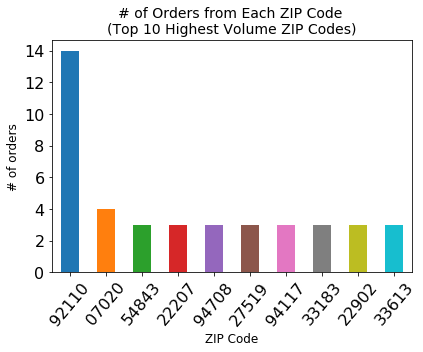

In [167]:
# Q: In which ZIP codes do most of our customers reside?
joint_grouped.head(10).plot(y='count', kind='bar', fontsize=16, legend=None, figsize=(6,5))
plt.xticks(rotation=50)
plt.title('# of Orders from Each ZIP Code \n(Top 10 Highest Volume ZIP Codes)', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('# of orders', fontsize=12)

#plt.show()
plt.tight_layout()
plt.savefig('plot1.png', dpi=300)

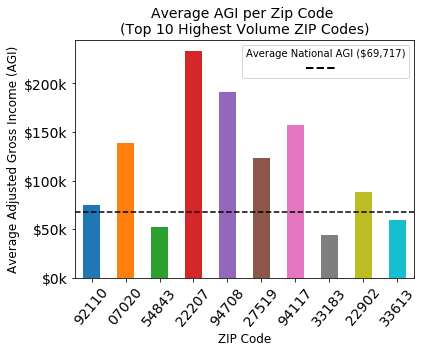

In [170]:
# Q: How wealthy are those ZIP Codes?
ax = joint_grouped.head(10).plot(y='avg_AGI', kind='bar', fontsize=14, figsize=(6,5))
plt.xticks(rotation=50)
plt.title('Average AGI per Zip Code \n(Top 10 Highest Volume ZIP Codes)', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('Average Adjusted Gross Income (AGI)', fontsize=12)
line = Line2D([], [], linewidth=2, linestyle="--", color='black')
plt.axhline(y=67.565, color='black', linestyle='--')
plt.legend(title='Average National AGI ($69,717)', handles=[line], handlelength=3) #(Calc. from demo_data_sum)

fmt = '${x:,.0f}k'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

#plt.show()
plt.tight_layout()
plt.savefig('plot2.png', dpi=300)

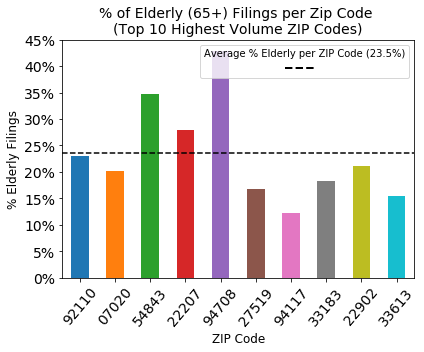

In [171]:
# Q: Can we get some idea of the age distribution of these ZIP codes?
ax = joint_grouped.head(10).plot(y='%_elderly', kind='bar', fontsize=14, figsize=(6,5))
plt.xticks(rotation=50)
plt.title('% of Elderly (65+) Filings per Zip Code \n(Top 10 Highest Volume ZIP Codes)', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('% Elderly Filings', fontsize=12)

line = Line2D([], [], linewidth=2, linestyle="--", color='black')
plt.axhline(y=23.5, color='black', linestyle='--')
plt.legend(title='Average % Elderly per ZIP Code (23.5%)', handles=[line], handlelength=3) #(Calc. from demo_data_sum)

fmt = '{x:,.0f}%'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

#plt.show()
plt.tight_layout()
plt.savefig('plot3.png', dpi=300)

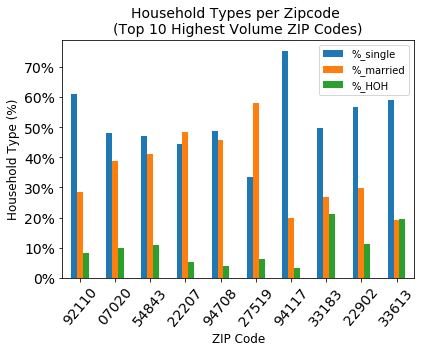

In [172]:
# Q: Single households vs. families?
ax = joint_grouped.head(10).plot(y=['%_single', '%_married', '%_HOH'], kind='bar', fontsize=14, figsize=(6,5))
plt.xticks(rotation=50)
plt.title('Household Types per Zipcode \n(Top 10 Highest Volume ZIP Codes)', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('Household Type (%)', fontsize=12)

fmt = '{x:,.0f}%'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

#plt.show()
plt.tight_layout()
plt.savefig('plot4.png', dpi=300)

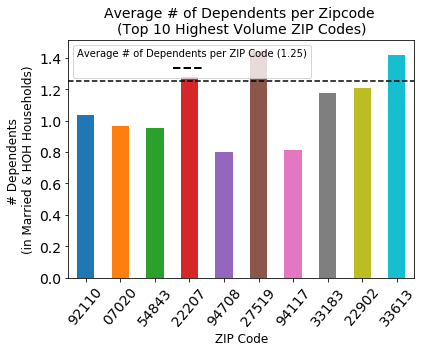

In [173]:
# Q: Average # of children in married & HOH households?
ax = joint_grouped.head(10).plot(y='avg_DEP', kind='bar', fontsize=14, figsize=(6,5))
plt.xticks(rotation=50)
plt.title('Average # of Dependents per Zipcode \n(Top 10 Highest Volume ZIP Codes)', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('# Dependents \n(in Married & HOH Households)', fontsize=12)

line = Line2D([], [], linewidth=2, linestyle="--", color='black')
plt.axhline(y=1.25, color='black', linestyle='--')
plt.legend(title='Average # of Dependents per ZIP Code (1.25)', handles=[line], handlelength=3) #(Calc. from demo_data_sum)

#plt.show()
plt.tight_layout()
plt.savefig('plot5.png', dpi=300)

# Explore purchase timing

In [119]:
amzn_data = amzn_data.set_index('purchase-date')

In [120]:
amzn_data.index = amzn_data.index.tz_localize('UTC').tz_convert('US/Eastern')
amzn_data = amzn_data.sort_index()
amzn_data = amzn_data.loc['2018'] #Only consider year 2018
print(amzn_data.head(5))
print(amzn_data.tail(5))

                               amazon-order-id ship-postal-code
purchase-date                                                  
2018-01-01 11:11:45-05:00  112-1835229-2605848            22207
2018-01-01 11:11:45-05:00  112-3147386-4255468            22207
2018-01-04 04:50:09-05:00  111-7765812-7480208            33020
2018-01-04 14:56:12-05:00  111-5993702-9229004            48854
2018-01-06 09:53:13-05:00  113-5758827-7801833            45231
                               amazon-order-id ship-postal-code
purchase-date                                                  
2018-12-26 16:54:38-05:00  114-8809939-2208254            60302
2018-12-26 17:35:35-05:00  114-9527398-7605029            10031
2018-12-26 22:29:13-05:00  113-2011911-5317005            90805
2018-12-27 10:52:30-05:00  114-3572626-5537048            33609
2018-12-28 16:09:12-05:00  112-3494590-9588255            98225


In [121]:
amzn_data_monthly = amzn_data.resample('M').count() \
    .drop('ship-postal-code', axis=1) \
    .rename(columns={'amazon-order-id':'num_orders'})
amzn_data_monthly['month'] = amzn_data_monthly.index.month
amzn_data_monthly['month_str'] = amzn_data_monthly.index.strftime('%b')
amzn_data_monthly

,num_orders,month,month_str
purchase-date,,,
2018-01-31 00:00:00-05:00,35,1,Jan
2018-02-28 00:00:00-05:00,9,2,Feb
2018-03-31 00:00:00-04:00,7,3,Mar
2018-04-30 00:00:00-04:00,9,4,Apr
2018-05-31 00:00:00-04:00,7,5,May
2018-06-30 00:00:00-04:00,9,6,Jun
2018-07-31 00:00:00-04:00,39,7,Jul
2018-08-31 00:00:00-04:00,39,8,Aug
2018-09-30 00:00:00-04:00,45,9,Sep


In [122]:
amzn_data_daily = amzn_data.groupby(amzn_data.index.weekday_name).count() \
    .drop('ship-postal-code', axis=1) \
    .rename(columns={'amazon-order-id':'num_orders'})
#amzn_data_daily['day'] = amzn_data.index.dayofweek
#amzn_data_daily['day_str'] = pd.to_datetime(amzn_data_daily.index).day_name()
amzn_data_daily.index = pd.Categorical(amzn_data_daily.index, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                                              "Saturday", "Sunday"])
amzn_data_daily = amzn_data_daily.sort_index()
#amzn_data_daily['day_of_week'] = amzn_data_daily.index.astype(str)
amzn_data_daily = amzn_data_daily.reset_index()
amzn_data_daily

,index,num_orders
0,Monday,38
1,Tuesday,22
2,Wednesday,32
3,Thursday,41
4,Friday,39
5,Saturday,65
6,Sunday,60


In [123]:
amzn_hourly = amzn_data.groupby(amzn_data.index.strftime('%H')).count() \
    .drop('ship-postal-code', axis=1) \
    .rename(columns={'amazon-order-id':'num_orders'})

#amzn_hourly['hour'] = amzn_hourly.index
amzn_hourly = amzn_hourly.reset_index()
amzn_hourly

,index,num_orders
0,00,13
1,01,6
2,02,4
3,04,1
4,05,5
5,06,2
6,07,8
7,08,3
8,09,13
9,10,7


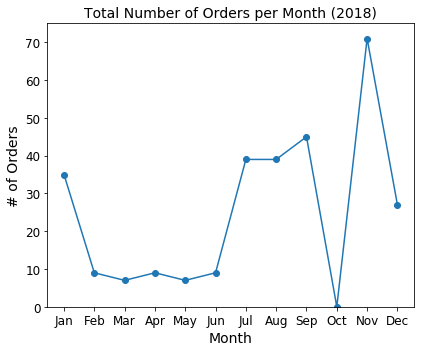

In [175]:
#Q: In what months do the majority of our customers make purchases?
ax = amzn_data_monthly.plot(x='month', y='num_orders', kind='line', fontsize=12, 
                            xticks=amzn_data_monthly['month'],
                           style='-o', legend=False, ylim=[0, 75], figsize=(6,5))
ax.set_xticklabels(amzn_data_monthly.index.strftime('%b'))
plt.title('Total Number of Orders per Month (2018)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('# of Orders', fontsize=14)

#plt.show()
plt.tight_layout()
plt.savefig('plot6.png', dpi=300)

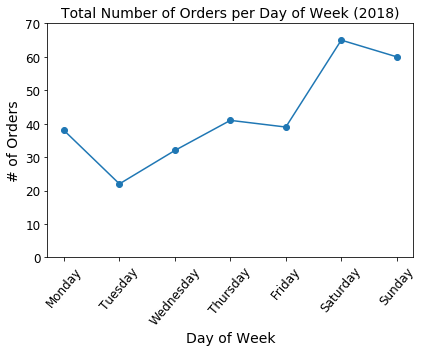

In [176]:
#Q: On what days do the majority of our customers make purchases?
#amzn_data_daily = amzn_data_daily.reset_index()
ax = amzn_data_daily.plot(x='index', y='num_orders', kind='line', fontsize=12, 
                                        xticks=amzn_data_daily.index,
                                       style='-o', legend=False, ylim=[0, 70], figsize=(6,5))
ax.set_xticklabels(amzn_data_daily['index'])
plt.xticks(rotation=50)
plt.title('Total Number of Orders per Day of Week (2018)', fontsize=14)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('# of Orders', fontsize=14)

#plt.show()
plt.tight_layout()
plt.savefig('plot7.png', dpi=300)

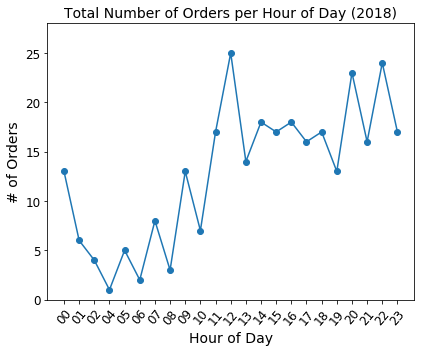

In [177]:
#Q: At what time of day do the majority of our customers make purchases?
#amzn_hourly = amzn_hourly.reset_index()
ax = amzn_hourly.plot(x='index', y='num_orders', kind='line', fontsize=12, 
                                        xticks=amzn_hourly.index,
                                       style='-o', legend=False, ylim=[0, 28], figsize=(6,5))
ax.set_xticklabels(amzn_hourly['index'])
plt.xticks(rotation=50)
plt.title('Total Number of Orders per Hour of Day (2018)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('# of Orders', fontsize=14)

#plt.show()
plt.tight_layout()
plt.savefig('plot8.png', dpi=300)

## Part 3: Statistical Inference

Q: I have chosen to analyze the top 10 ZIP codes by volume... How representative are these ZIP codes of all the other ZIP codes from which we received orders?

+ Use Chi-Squared Goodness of Fit test!
+ Metrics: AGI, ELDERLY, # dependents
+ Null Hypothesis: Sample containing Top 10 ZIP Codes has same distribution in above metrics as total population.
+ Alternative Hypothesis: Sample containing Top 10 ZIP Codes has significantly different distribution than total population.
+ Significance level (alpha): 0.05

In [127]:
#AGI
chi_AGI = 0
avg_AGI = 69.717
for row in joint_grouped.head(10).itertuples():
    zip_chi = (((row[9] - avg_AGI) ** 2) / avg_AGI)
    chi_AGI += zip_chi
print chi_AGI #Chi^2 = 835.22 => p ~ 0 => NULL HYPOTHESIS REJECTED!

835.215179183


In [128]:
#Elderly
chi_elderly = 0
avg_eld = 23.5
for row in joint_grouped.head(10).itertuples():
    eld_chi = (((row[13] - avg_eld) ** 2) / avg_eld)
    chi_elderly += eld_chi
print chi_elderly #Chi^2 = 34.14 => p = 0.00008 => NULL HYPOTHESIS REJECTED!

34.1393020958


In [129]:
#Dependents
chi_dep = 0
avg_dep = 1.25
for row in joint_grouped.head(10).itertuples():
    dep_chi = (((row[14] - avg_dep) ** 2) / avg_dep)
    chi_dep += dep_chi
print chi_dep #Chi^2 = 0.55 => p = 0.99995 => NULL HYPOTHESIS ACCEPTED!

0.548796300425


## Conclusion

Comparing the top 10 ZIP codes by volume with the rest of the order population revealed that the only metric along which the top 10 distribution was a strong representation (by the Chi-squared goodness of fit test) was number of dependents. The top 10 sample was significantly different in both its average AGI and % elderly population.

My recommendations in light of this analysis are mixed: On one hand, the fact that our highest volume ZIP codes differed so greatly in average AGI and % elderly suggests that those two metrics are prime candidates for targeted marketing efforts. On the other hand, the fact that our total order sample is still relatively small, and the top 10 ZIP codes, as yet, comprise only a small overall percentage of our total sales, it may be unwise to focus too narrowly on those metrics at the expense of others. Both more data and more analysis are required before firmer conclusions can be drawn.

## Part 4: Machine Learning

Objective: Use supervised or unsupervised learning techniques to augment the data analysis

No data to train on to make predictions... so use clustering to uncover customer segments!

In [130]:
from sklearn.cluster import KMeans

In [131]:
#new_amzn_df = amzn_data.reset_index()
#new_amzn_df = new_amzn_df.drop('purchase-date', axis=1)
#new_amzn_df.head()

In [132]:
new_amzn_df = amzn_data_RAW[['amazon-order-id', 'ship-postal-code', 'item-price']]
#new_amzn_df = new_amzn_df.drop('purchase-date', axis=1)
new_amzn_df.head()

,amazon-order-id,ship-postal-code,item-price
0,113-9235397-9394658,02118-1089,74.99
1,112-1718234-0365053,98802-2603,74.99
2,111-1795457-0212247,64506,74.99
3,114-9388024-7222668,94022-1209,59.99
4,112-7199274-2267420,80231-4510,59.99


In [133]:
cluster_df = new_amzn_df.merge(joint_grouped.reset_index(), left_on='ship-postal-code', right_on='zipcode')
cluster_df = cluster_df[['amazon-order-id', 'item-price', 'N1', 'avg_AGI', 'NUMDEP', '%_elderly']]
cluster_df.head()

,amazon-order-id,item-price,N1,avg_AGI,NUMDEP,%_elderly
0,111-1795457-0212247,74.99,10080,64.657242,5270,32.440476
1,114-1820375-9374655,74.99,9830,39.191963,7280,20.854527
2,114-5537230-7035440,59.99,1980,49.058081,1660,21.717172
3,111-3030846-5669813,24.99,11780,54.052207,6550,25.212224
4,114-9465164-0336206,59.99,14280,70.226190,9120,27.100840


In [134]:
cluster_matrix = cluster_df.values[:,1:]
print(cluster_matrix)

[[74.99 10080 64.65724206349206 5270 32.44047619047619]
 [74.99 9830 39.19196337741607 7280 20.854526958290943]
 [59.99 1980 49.05808080808081 1660 21.71717171717172]
 [24.99 11780 54.052207130730054 6550 25.21222410865874]
 [59.99 14280 70.22619047619048 9120 27.100840336134453]
 [69.24 7820 143.81815856777493 2070 18.414322250639387]
 [69.24 7820 143.81815856777493 2070 18.414322250639387]
 [54.74 16840 38.88705463182898 12770 18.34916864608076]
 [69.24 13650 64.53142857142858 5640 21.904761904761905]
 [11.99 1530 46.6797385620915 780 29.411764705882355]
 [54.74 1530 46.6797385620915 780 29.411764705882355]
 [11.99 13460 154.40869242199108 7290 36.10698365527489]
 [54.74 7650 57.38078431372549 4220 27.18954248366013]
 [54.74 8110 334.17422934648584 6710 27.62022194821208]
 [54.74 8110 334.17422934648584 6710 27.62022194821208]
 [69.24 20720 209.17818532818532 8430 29.633204633204635]
 [54.74 4870 572.5845995893224 1440 51.74537987679672]
 [54.74 21710 48.304882542607096 12720 22.0635

Don't know optimal # of clusters in advance... so let's try different values

In [135]:
def getKMeansSS(arr, n_clusters):
    km = KMeans(n_clusters=n_clusters).fit(arr)
    return km.inertia_

In [136]:
SS_list = []
for n in range(2, 11):
    SS_list.append(getKMeansSS(cluster_matrix, n))
print(SS_list)

[5067491833.734605, 2837856917.339677, 1955883325.838297, 1377825440.7177343, 1057549515.570524, 856975008.7563266, 720215076.3309726, 613526685.0503652, 558601911.9397523]


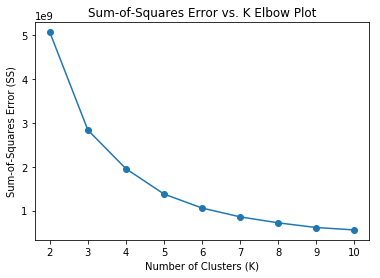

In [137]:
plt.plot(range(2,11), SS_list, '-o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum-of-Squares Error (SS)')
plt.title('Sum-of-Squares Error vs. K Elbow Plot')
plt.show() #K=4?

In [138]:
#Elbow plot looks pretty nice... Try again with scaling for comparison

from sklearn.preprocessing import StandardScaler

scaled_cm = StandardScaler().fit_transform(cluster_matrix)
print(scaled_cm)

[[ 7.84016065e-01 -4.30311685e-01 -4.05926164e-01 -3.95210731e-01
   7.78514630e-01]
 [ 7.84016065e-01 -4.60562354e-01 -6.44809764e-01 -7.80898312e-02
  -4.37363495e-01]
 [ 5.35826640e-02 -1.41043337e+00 -5.52258111e-01 -9.64766178e-01
  -3.46833935e-01]
 [-1.65076194e+00 -2.24607133e-01 -5.05409423e-01 -1.93263093e-01
   1.99515280e-02]
 [ 5.35826640e-02  7.78995617e-02 -3.53685210e-01  2.12209898e-01
   2.18150839e-01]
 [ 5.04016595e-01 -7.03777736e-01  3.36663187e-01 -9.00079825e-01
  -6.93448816e-01]
 [ 5.04016595e-01 -7.03777736e-01  3.36663187e-01 -9.00079825e-01
  -6.93448816e-01]
 [-2.02069026e-01  3.87666417e-01 -6.47670039e-01  7.88076208e-01
  -7.00286309e-01]
 [ 5.04016595e-01  1.66787475e-03 -4.07106390e-01 -3.36835242e-01
  -3.27147433e-01]
 [-2.28380422e+00 -1.46488458e+00 -5.74568762e-01 -1.10360518e+00
   4.60668939e-01]
 [-2.02069026e-01 -1.46488458e+00 -5.74568762e-01 -1.10360518e+00
   4.60668939e-01]
 [-2.28380422e+00 -2.13226340e-02  4.36010415e-01 -7.65121153e-02

In [139]:
SS_list2 = []
for n in range(2, 11):
    SS_list2.append(getKMeansSS(scaled_cm, n))
print(SS_list2)

[400.4038520214077, 332.88979895064347, 280.47650414995627, 230.9754592891527, 197.27507943458485, 177.35033581957714, 159.5055853819162, 136.0114541773293, 120.29440703107994]


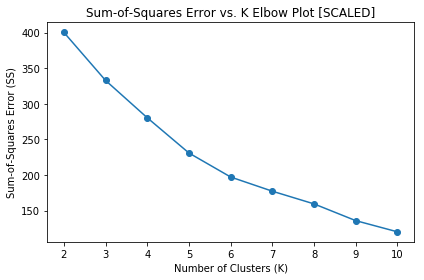

In [181]:
plt.plot(range(2,11), SS_list2, '-o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum-of-Squares Error (SS)')
plt.title('Sum-of-Squares Error vs. K Elbow Plot [SCALED]')
#plt.show() #No clear elbow point... K=5 for optimal value?
plt.tight_layout()
plt.savefig('plot_elbow.png', dpi=300)

In [141]:
#Try silhouette scores to determine K (# of clusters)
from sklearn.metrics import silhouette_score

In [142]:
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_cm)

    silhouette_avg = silhouette_score(scaled_cm, cluster_labels)
    #silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
#Silhouette scoring finds weak cluster structures for every value of K between 2 and 10,
#and all scores are about the same (0.25-0.28). K=3 consistently has highest silhouette score at ~0.28.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.26745823113621636)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.26099518973177915)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.27366114449063467)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.2635596870904217)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.2525196981059054)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.2535344042177265)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.23304355371680363)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.26273257684028306)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.2635616507537304)


In [143]:
#Perform PCA for visual plotting to attempt to manually identify clusters
from sklearn.decomposition import PCA

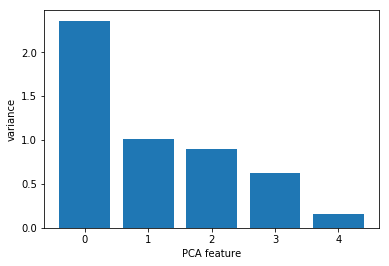

In [144]:
pca = PCA()
pca.fit(scaled_cm)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [145]:
print pd.DataFrame(pca.components_,columns=cluster_df.columns[1:],index = ['PC-0', 'PC-1', 'PC-2', 'PC-3', 'PC-4'])

      item-price        N1   avg_AGI    NUMDEP  %_elderly
PC-0    0.188868  0.581663 -0.287017  0.580227  -0.454923
PC-1    0.726776  0.137182  0.623358  0.112579   0.227437
PC-2    0.658022 -0.286968 -0.579484 -0.346386  -0.169919
PC-3   -0.035797 -0.263286  0.437462 -0.168491  -0.842399
PC-4    0.043023 -0.700842 -0.043259  0.708724   0.052996


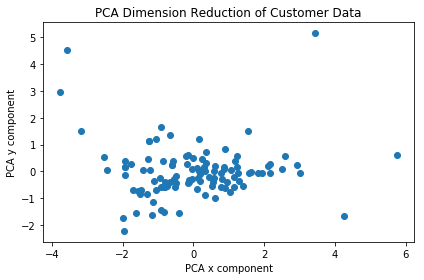

In [184]:
#Looks like 4 components making significant contributions... but let's reduce to 2 for ease of visualization
pca2 = PCA(n_components=2)
reduced_cm = pca2.fit_transform(scaled_cm)

df_pca = pd.DataFrame()
df_pca['Order_ID'] = cluster_df['amazon-order-id']
df_pca['pca_x'] = reduced_cm[:,0]
df_pca['pca_y'] = reduced_cm[:,1]

plt.scatter('pca_x', 'pca_y', data=df_pca)
plt.xlabel('PCA x component')
plt.ylabel('PCA y component')
plt.title('PCA Dimension Reduction of Customer Data')
#plt.show() #No visually discernable clusters w/ 2 components...
plt.tight_layout()
plt.savefig('plot_pca.png', dpi=300)

In [147]:
#Try some alternate clustering algorithms...
from sklearn.cluster import AffinityPropagation, DBSCAN

In [148]:
# Affinity Propagation
aff_cluster = AffinityPropagation().fit(cluster_matrix)
print(len(aff_cluster.cluster_centers_[:,0])) #11 clusters for unscaled data

aff_cluster2 = AffinityPropagation().fit(scaled_cm)
print(len(aff_cluster2.cluster_centers_[:,0])) #16 clusters for scaled data

11
16


In [149]:
#Will we get better silhouette scores for these higher number of clusters?
for n_clusters in range(11,21):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_cm)

    silhouette_avg = silhouette_score(scaled_cm, cluster_labels)
    #silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
#Nope.

('For n_clusters =', 11, 'The average silhouette_score is :', 0.254952508752661)
('For n_clusters =', 12, 'The average silhouette_score is :', 0.24519075556821904)
('For n_clusters =', 13, 'The average silhouette_score is :', 0.2456272083000571)
('For n_clusters =', 14, 'The average silhouette_score is :', 0.23253809886708574)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.2383551128571536)
('For n_clusters =', 16, 'The average silhouette_score is :', 0.2252027255731709)
('For n_clusters =', 17, 'The average silhouette_score is :', 0.23949846511323422)
('For n_clusters =', 18, 'The average silhouette_score is :', 0.2387213601344807)
('For n_clusters =', 19, 'The average silhouette_score is :', 0.2395441083202576)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.22544903874874553)


Number of clusters found: 4


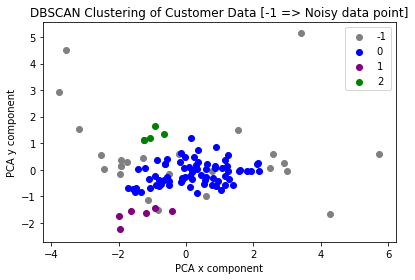

In [186]:
db_cluster_labels = DBSCAN(eps=1.0).fit_predict(scaled_cm) #Experimentation finds eps=~1.0 to be optimal
#print(db_cluster_labels)
print('Number of clusters found: %d' % len(set(db_cluster_labels)))

df_pca['DBSCAN_Labels'] = db_cluster_labels
c_dict = {-1:'gray', 0:'blue', 1:'purple', 2:'green'}

fig, ax = plt.subplots()

for v in sorted(df_pca['DBSCAN_Labels'].unique()):
    df_pca_slice = df_pca[df_pca['DBSCAN_Labels'] == v]
    ax.scatter('pca_x', 'pca_y', c=c_dict[v], label=v, data=df_pca_slice)
    ax.legend()

#plt.scatter('pca_x', 'pca_y', c='DBSCAN_Labels', data=df_pca)
plt.xlabel('PCA x component')
plt.ylabel('PCA y component')
plt.title('DBSCAN Clustering of Customer Data [-1 => Noisy data point]')
#plt.show() #DBSCAN finds 3 clusters (after throwing out points classified as "noise")
plt.tight_layout()
plt.savefig('plot_dbscan.png', dpi=300)

In [151]:
#Inspect clusters for patterns (start with small clusters '1' and '2')

cluster1 = df_pca[df_pca['DBSCAN_Labels'] == 1]['Order_ID']
cluster1_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster1)]
print(cluster1_orders) #Low AGI (45-60) AND Low item-price

cluster2 = df_pca[df_pca['DBSCAN_Labels'] == 2]['Order_ID']
cluster2_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster2)]
print(cluster2_orders) #Very high AGI

cluster0 = df_pca[df_pca['DBSCAN_Labels'] == 0]['Order_ID']
cluster0_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster0)]
print(cluster0_orders.describe()) #Everything else

        amazon-order-id  item-price     N1    avg_AGI  NUMDEP  %_elderly
3   111-3030846-5669813       24.99  11780  54.052207    6550  25.212224
9   113-4809003-4725858       11.99   1530  46.679739     780  29.411765
20  112-6604499-3434658       24.99   5460  51.232234    2840  34.065934
22  111-5993702-9229004       24.99   9470  64.509293    5390  29.672650
32  114-9640146-7795400       54.74   5670  61.466843    3860  26.455026
33  114-9640146-7795400       24.99   5670  61.466843    3860  26.455026
78  114-7885015-6095451       24.99    960  47.631250     720  31.250000
        amazon-order-id  item-price     N1     avg_AGI  NUMDEP  %_elderly
13  113-8614052-1955451       54.74   8110  334.174229    6710  27.620222
14  112-8074674-1833004       54.74   8110  334.174229    6710  27.620222
47  114-5574680-7312225       54.74  12370  309.544220    7530  32.659660
62  112-1637424-7571426       69.24  14570  272.052917    7510  37.886067
84  112-3766236-2844259       54.74  15460  33

In [152]:
#Since DBSCAN seems to have worked fairly well, let's try HDBSCAN, an upgraded version of DBSCAN
#(From the same authors as DBSCAN: https://github.com/scikit-learn-contrib/hdbscan)

import hdbscan

Number of clusters found: 4


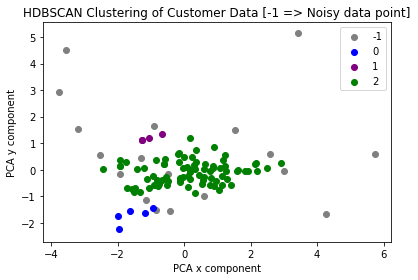

In [187]:
#Try min_cluster_size = 3

clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
hdb_cluster_labels = clusterer.fit_predict(scaled_cm)
print('Number of clusters found: %d' % len(set(hdb_cluster_labels)))

df_pca['HDBSCAN_Labels'] = hdb_cluster_labels
c_dict = {-1:'gray', 0:'blue', 1:'purple', 2:'green'}

fig, ax = plt.subplots()

for v in sorted(df_pca['HDBSCAN_Labels'].unique()):
    df_pca_slice = df_pca[df_pca['HDBSCAN_Labels'] == v]
    ax.scatter('pca_x', 'pca_y', c=c_dict[v], label=v, data=df_pca_slice)
    ax.legend()

#plt.scatter('pca_x', 'pca_y', c='DBSCAN_Labels', data=df_pca)
plt.xlabel('PCA x component')
plt.ylabel('PCA y component')
plt.title('HDBSCAN Clustering of Customer Data [-1 => Noisy data point]')
#plt.show() #Very similar to DBSCAN result, but leaves out a couple of close points clustered by DBSCAN
plt.tight_layout()
plt.savefig('plot_hdbscan.png', dpi=300)

In [154]:
#Inspect HBDSCAN clusters for patterns (start with small clusters '0' and '1')

cluster0h = df_pca[df_pca['HDBSCAN_Labels'] == 0]['Order_ID']
cluster0h_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster0h)]
print(cluster0h_orders)

cluster1h = df_pca[df_pca['HDBSCAN_Labels'] == 1]['Order_ID']
cluster1h_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster1h)]
print(cluster1h_orders)

cluster2h = df_pca[df_pca['HDBSCAN_Labels'] == 2]['Order_ID']
cluster2h_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster2h)]
print(cluster2h_orders.describe())

#No visually discernible distinct cluster features...

        amazon-order-id  item-price    N1    avg_AGI  NUMDEP  %_elderly
9   113-4809003-4725858       11.99  1530  46.679739     780  29.411765
20  112-6604499-3434658       24.99  5460  51.232234    2840  34.065934
22  111-5993702-9229004       24.99  9470  64.509293    5390  29.672650
32  114-9640146-7795400       54.74  5670  61.466843    3860  26.455026
33  114-9640146-7795400       24.99  5670  61.466843    3860  26.455026
78  114-7885015-6095451       24.99   960  47.631250     720  31.250000
        amazon-order-id  item-price     N1     avg_AGI  NUMDEP  %_elderly
13  113-8614052-1955451       54.74   8110  334.174229    6710  27.620222
14  112-8074674-1833004       54.74   8110  334.174229    6710  27.620222
47  114-5574680-7312225       54.74  12370  309.544220    7530  32.659660
84  112-3766236-2844259       54.74  15460  332.293920    9220  30.789133
       item-price            N1     avg_AGI        NUMDEP  %_elderly
count   86.000000     86.000000   86.000000     86.000000

Number of clusters found: 4


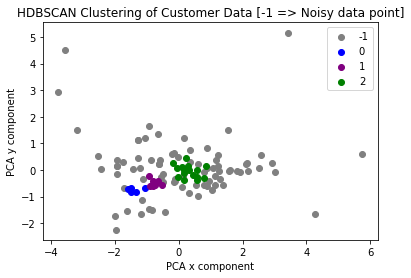

In [155]:
#Try min_cluster_size = 4

clusterer = hdbscan.HDBSCAN(min_cluster_size=4)
hdb_cluster_labels = clusterer.fit_predict(scaled_cm)
print('Number of clusters found: %d' % len(set(hdb_cluster_labels)))

df_pca['HDBSCAN_Labels'] = hdb_cluster_labels
c_dict = {-1:'gray', 0:'blue', 1:'purple', 2:'green'}

fig, ax = plt.subplots()

for v in sorted(df_pca['HDBSCAN_Labels'].unique()):
    df_pca_slice = df_pca[df_pca['HDBSCAN_Labels'] == v]
    ax.scatter('pca_x', 'pca_y', c=c_dict[v], label=v, data=df_pca_slice)
    ax.legend()

#plt.scatter('pca_x', 'pca_y', c='DBSCAN_Labels', data=df_pca)
plt.xlabel('PCA x component')
plt.ylabel('PCA y component')
plt.title('HDBSCAN Clustering of Customer Data [-1 => Noisy data point]')
plt.show() #Clusters are smaller and leave out a lot of neighboring points. min_cluster_size=3 seems better.


**Conclusion:**

Initially, our customers did not seem to be clustered along the metrics I have chosen to analyze (price of items purchased, number of filings [proxy for ZIP code size], average AGI, average number of dependents, and average % elderly population). However, after experimenting with other clustering algorithms, I found that DBSCAN suggests 3 clusters (along with many noisy points). Manual inspection of the smaller two of these DBSCAN clusters reveals similarities between the orders therein, suggesting that the clusterings are indeed legitimate. Both clusters are very small though (5 and 7 samples, respectively), and the 3rd, larger, cluster is fairly broad and generic, essentially representing the average of our customer base. More samples would hopefully either enlarge these smaller clusters (thus increasing confidence in their legitimacy) or reveal new clusters.

It is difficult to say why HDBSCAN seems to provide a worse solution than DBSCAN, when, in theory, it should be all-around superior to it. But it makes some sense that DBSCAN would perform better than the other algorithms. For one thing, it is the only algorithm that attempts to deal with "noise", separating those points from the "meaningful" data in this 5-dimensional feature space. It is also very good at capturing non-linearly separable clusters (unlike many other algorithms which can only find globular clusters). The DBSCAN parameter eps required some experimentation to tune, but the algorithm produced a solid result at eps ~1.0.